In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Setup complete.')


Setup complete.


<AxesSubplot:ylabel='Season'>

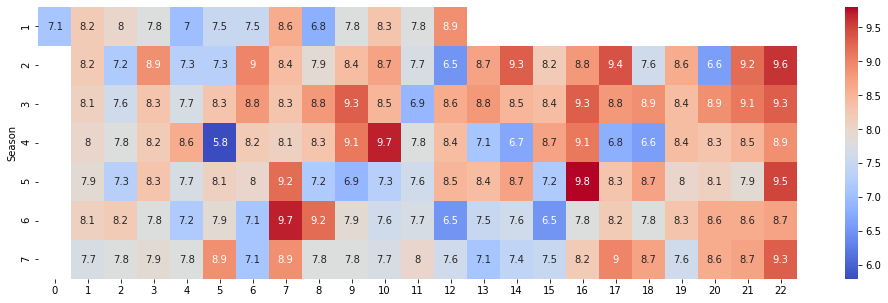

In [3]:
ratings_filepath = '../input/buffy-the-vampire-slayer/buffy_ratings.csv'
ratings = pd.read_csv(ratings_filepath, index_col='Season')
plt.figure(figsize=(17,5))
sns.heatmap(data=ratings, cmap='coolwarm', annot=True)

In [4]:
import re

def get_script(season, episode, all_scripts):
    script_re = "<--SEASON %d EPISODE %d.*?-->"%(season, episode)
    script = re.search(script_re, all_scripts, re.DOTALL)
    if script == None:
        return "No such script found."
    return script.group(0)

def get_dialogue_regex():
    char_re_1 = "[a-zA-Z]+(?=[:\n])" # Upper- or lower-case name followed by colon or newline.
    char_re_2 = "[A-Z]+(?=\s)" # Upper-case character name followed by whitespace.
    dialogue_re = "([^\n]+?)(?=[$\n])" # Go until newline or end of string.
    return re.compile("\n *(" + char_re_1 + "|" + char_re_2 +")[:\s]*" + dialogue_re)

def clean_name_string(name, nicknames = {}):
    name = name.upper().strip()
    if name in nicknames:
        name = nicknames[name]
    return name;

def clean_dialogue(line):
    return line.strip()

def script_to_df(script):
    reg = get_dialogue_regex()
    lines = re.findall(reg, script)
    rows = []
    for line in lines:
        if len(line[0]) > 1:
            character = clean_name_string(line[0])
        else:
            continue
        dialogue = clean_dialogue(line[1])
        rows.append((character, dialogue))
    return pd.DataFrame(rows, columns=["Name", "Dialogue"])

def all_scripts_to_df(all_scripts):
    season = episode = 1
    season_exists = episode_exists = True
    df_list = []
    while season_exists:
        while episode_exists:
            #print("Parsing season %d episode %d"%(season, episode))
            script = get_script(season, episode, all_scripts)
            if len(script) < 200:
                if episode == 1:
                    return pd.concat(df_list, ignore_index=True)
                season += 1
                episode = 1
            else:
                df = script_to_df(script)
                df.insert(0, "Season", season)
                df.insert(1, "Episode", episode)
                df_list.append(df)
                episode += 1

In [5]:
all_scripts = open('../input/buffyallscripts/buffy_scripts.text').read()
df = all_scripts_to_df(all_scripts)
df.head()

,Season,Episode,Name,Dialogue
0,1,1,DARLA,Are you sure this is a good idea?
1,1,1,BOY,"It's a great idea, now come on."
2,1,1,DARLA,Do you go to school here?
3,1,1,BOY,I used to. On top of the gym it's so cool. You...
4,1,1,DARLA,"I, I, I, I don't wanna go up there."


In [6]:
import random
import spacy
from sklearn.model_selection import train_test_split

poi_list = ['BUFFY', 'GILES'] # People of interest.
poi_data = df[(df.Name.isin(poi_list))].copy()
print(len(poi_data))

nlp = spacy.blank('en')
textcat = nlp.create_pipe(
            'textcat',
            config = {
                'exclusive_classes': True,
                'architecture': 'bow'
            }
        )
nlp.add_pipe(textcat)
for name in poi_list:
    textcat.add_label(name.lower())
print("Textcat labels: ", textcat.labels)
    
poi_dialogue = poi_data['Dialogue'].values
poi_labels = poi_data['Name'].values
X_train, X_test, y_train, y_test = train_test_split(poi_dialogue, poi_labels, test_size = 0.3, stratify=poi_labels)

category_labels = [{'cats': {poi_name.lower(): name==poi_name for poi_name in poi_list}} for name in y_train]
Xy_train = list(zip(X_train, category_labels))
Xy_test = list(zip(X_test, y_test))
Xy_train[:5]

16913
Textcat labels:  ('buffy', 'giles')


[("(sees Debbie's bouquet) Those are pretty flowers.",
  {'cats': {'buffy': True, 'giles': False}}),
 ('(walking away) Sorry. My office hours are 10 to 4.',
  {'cats': {'buffy': True, 'giles': False}}),
 ('Willow, down!', {'cats': {'buffy': True, 'giles': False}}),
 ("OK. But you've been fine. In close contact with the girls.",
  {'cats': {'buffy': True, 'giles': False}}),
 ("Well, I don't.", {'cats': {'buffy': True, 'giles': False}})]

In [7]:
from spacy.util import minibatch

spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(20):
    random.shuffle(Xy_train)
    batches = minibatch(Xy_train, size=28)
    for batch in batches:
        lines, labels = zip(*batch)
        nlp.update(lines, labels, sgd=optimizer, losses=losses)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}", losses)


Epoch 0 {'textcat': 0.17930792468541767}
Epoch 5 {'textcat': 0.7446067947275878}
Epoch 10 {'textcat': 1.1631380937815265}
Epoch 15 {'textcat': 1.516496373253176}


In [10]:
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict([nlp.tokenizer(line[0]) for line in Xy_test])
predicted_labels = scores.argmax(axis=1)
num_correct = 0
incorrectly_classified = []
for i in range(len(Xy_test)):
    pred_label = textcat.labels[predicted_labels[i]]
    if Xy_test[i][1].lower() == pred_label:
        num_correct += 1
    else:
        incorrectly_classified.append((Xy_test[i], pred_label))
print('Percent correct: %f'%(num_correct / len(Xy_test)))
print('-'*30)
print('Sample of incorrectly classified lines of dialogue:')
incorrect_sample = random.sample(incorrectly_classified, 10)
for i in range(10):
    print(incorrect_sample[i])

Percent correct: 0.824399
------------------------------
Sample of incorrectly classified lines of dialogue:
(('Mm-hmm.', 'GILES'), 'buffy')
(("Of course not. That's how all Slayer/Watcher relationships end, isn't it?", 'GILES'), 'buffy')
(("Hmm. So you've read something about the feeling?", 'BUFFY'), 'giles')
(('Sorry...', 'GILES'), 'buffy')
(('(checks watch) 4:24.', 'BUFFY'), 'giles')
(("Well, it appears she's never heard the fable about patience.", 'GILES'), 'buffy')
(('The Council?', 'BUFFY'), 'giles')
(("Here. (hands her a cup) Drink that, and then I'll drive you home.", 'GILES'), 'buffy')
(('Lemme see. (lifts up his shirt a little to inspect his ribs)', 'BUFFY'), 'giles')
(('"Third new moon after the . . . nine-hundredth feast of Delthrox." Oh, (stands up) crap.', 'GILES'), 'buffy')
